# openEO Demonstration

This notebook can either be run through the Jupyter interface or run using the `papermill` command line tool.

#### Jupyter

Ensure that your `~/.eoepca/state` file is correctly filled, or the necessary environment variables are set before running the notebook.

#### Papermill

To run the notebook using `papermill`, use the following command:

```bash
papermill \
  -p openeo_backend "openeo.notebook-test.develop.eoepca.org" \
  -p authentication_method "authorization-code" \
  openeo.ipynb \
  openeo-output.ipynb \
  --log-output
```

This will run the notebook and save the output to `openeo-output.ipynb`.

You can experiment with the different parameters e.g. to try with a different user you could do

```bash
papermill \
  -p openeo_backend "openeo.notebook-test.develop.eoepca.org" \
  -p authentication_method "authorization-code" \
  -p username "differentuser" \
  -p password "differentpassword" \
  openeo.ipynb \
  openeo-test.ipynb \
  --log-output
```

## Setup

In [ ]:
import os
import openeo
import json
import xarray
import matplotlib.pyplot as pyplot

from modules.helpers import get_access_token, load_eoepca_state, test_cell, test_results

Load `eoepca state` environment

In [ ]:
load_eoepca_state()

In [3]:
platform_domain = os.environ.get("INGRESS_HOST")

openeo_backend = f"openeo.{platform_domain}"
authentication_method = "device-code-flow" # or authorization-code

username = os.environ.get("KEYCLOAK_TEST_USER")
password = os.environ.get("KEYCLOAK_TEST_PASSWORD")
client_id = os.environ.get("OPENEO_CLIENT_ID")

collection_id = "TestCollection-LonLat16x16"
temporal_extent = "2024-09"
spatial_extent = {"west": 3, "south": 51, "east": 5, "north": 53}

log_output_file = "openeo_log.json"

In [4]:
print(f"Parameters:\n"
f"Platform domain: {platform_domain}\n"
f"OpenEO backend: {openeo_backend}\n"
f"Authentication method: {authentication_method}\n"
f"Collection ID: {collection_id}\n"
f"Temporal extent: {temporal_extent}\n"
f"Spatial extent: {spatial_extent}")

Parameters:
Platform domain: notebook-test.develop.eoepca.org
OpenEO backend: openeo.notebook-test.develop.eoepca.org
Authentication method: device-code-flow
Collection ID: TestCollection-LonLat16x16
Temporal extent: 2024-09
Spatial extent: {'west': 3, 'south': 51, 'east': 5, 'north': 53}


## Connect to the openEO backend

In [ ]:
# authentication
connection = openeo.connect(url=openeo_backend)
if authentication_method == "device-code-flow":
    connection.authenticate_oidc()
elif authentication_method == "authorization-code":
    access_token = get_access_token(username, password, client_id)
    auth_token = f"oidc/eoepca/{access_token}"
    connection.session.headers.update({"Authorization": f"Bearer {auth_token}"})

Visit https://iam-auth.apx.develop.eoepca.org/realms/eoepca/device?user_code=DXTE-XHAF 📋 to authenticate.

✅ Authorized successfully

Authenticated using device code flow.


In [6]:
if authentication_method == "device-code-flow":
    print("Visit this backend through Web Editor:\n" + connection.web_editor(anonymous=True))

Visit this backend through Web Editor:
https://editor.openeo.org/?server=https%3A%2F%2Fopeneo.notebook-test.develop.eoepca.org%2Fopeneo%2F1.2%2F&discover=1


## Exploration

Available collections:

In [7]:
# collection_exists
available_collections = connection.list_collection_ids()
assert collection_id in available_collections

Available processes:

In [8]:
# list_processes
[p["id"] for p in connection.list_processes()[:10]]

['array_apply',
 'arccos',
 'arcosh',
 'power',
 'last',
 'subtract',
 'not',
 'cosh',
 'artanh',
 'is_valid']

## Simple processing

In [9]:
# process_execution
process_graph = {
    "add": {
        "process_id": "add",
        "arguments": {"x": 3, "y": 5},
        "result": True,
    },
}

result = connection.execute(process_graph)

## Raster processing

Raster processing with built-in dummy collection (which does not require direct access to actual EO data).

In [13]:
# data_loading
cube = connection.load_collection(
    collection_id=collection_id,
    temporal_extent=temporal_extent,
    spatial_extent=spatial_extent,
    bands=["Longitude", "Latitude", "Day"],
)

In [14]:
%%time
cube.download("openeo-lonlat1616.nc")

CPU times: user 3.16 ms, sys: 2.65 ms, total: 5.81 ms
Wall time: 705 ms


Inspect downloaded results:

In [15]:
# raster_download
ds = xarray.load_dataset("openeo-lonlat1616.nc")
ds;


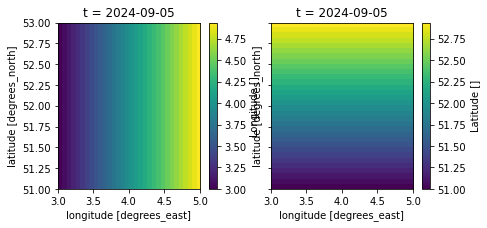

In [16]:
fig, axes = pyplot.subplots(ncols=2, figsize=(7, 3), dpi=72, sharey=True)

ds["Longitude"].isel(t=0).plot.imshow(ax=axes[0])
ds["Latitude"].isel(t=0).plot.imshow(ax=axes[1]);

## Real raster processing with `load_stac`

`load_stac` is an standard openEO process that allows to load EO data that is hosted externally through the STAC standard.

In [17]:
# raster_open
stac_url = "https://raw.githubusercontent.com/Open-EO/openeo-geopyspark-driver/refs/heads/master/docker/local_batch_job/example_stac_catalog/collection.json"

cube = connection.load_stac(
    url=stac_url,
    temporal_extent=["2023-06-01", "2023-06-09"],
    spatial_extent={"west": 5.07, "south": 51.215, "east": 5.08, "north": 51.22},
    bands=["B04", "B03", "B02"],
)

Simple "band math" based processing, to calculate some NDVI-like index:

In [18]:
# band_math
b04 = cube.band("B04")
b02 = cube.band("B02")
n42 = (b04 - b02) / (b04 + b02)

Trigger processing and download result synchronously:

In [ ]:
# nc_download
n42.download("openeo-load_stac-n42-sync.nc")

UsageError: Line magic function `%%time` not found.


Inspect result:

In [ ]:
# xarray_load_dataset
ds = xarray.load_dataset("openeo-load_stac-n42-sync.nc")
ds;

Dataset: <xarray.Dataset> Size: 52kB
Dimensions:  (t: 3, x: 73, y: 58)
Coordinates:
  * t        (t) datetime64[ns] 24B 2023-06-01 2023-06-04 2023-06-06
  * x        (x) float64 584B 6.446e+05 6.446e+05 ... 6.453e+05 6.453e+05
  * y        (y) float64 464B 5.676e+06 5.676e+06 ... 5.676e+06 5.676e+06
Data variables:
    crs      |S1 1B b''
    var      (t, y, x) float32 51kB 0.2153 0.2179 0.227 ... -0.03759 -0.1307
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform


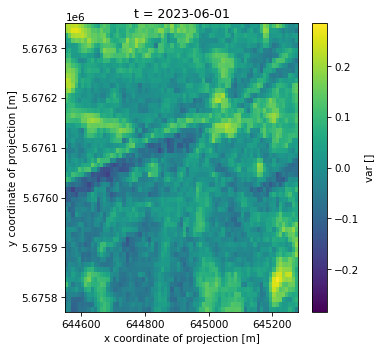

In [ ]:
# plot_figure
fig, ax = pyplot.subplots(dpi=75, figsize=(5, 5))
# purposefully fail, divide by 0
# will_fail = 1 / 0

ds["var"].isel(t=0).plot.imshow(ax=ax, cmap="viridis");

In [ ]:
for test, result in test_results.items():
    print(f"{test}: {result['status']} - {result['message']}")
json.dump(test_results, open(log_output_file, "w"), indent=2)